In [1]:
!pip install transformers

In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer


In [4]:
df = pd.read_csv('/content/augmented_data (1).csv')
df.head()

,Questions,Blooms Taxonomy
0,Given is an array after the first partition of...,remember
1,How many steps are required to solve Tower of ...,remember
2,How many comparisons are required to find elem...,remember
3,"Given an array A[-3:4, 6:10], Find the address...",remember
4,"Consider the following list of 10 numbers: 35,...","apply , remember"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2808 entries, 0 to 2807
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Questions        2808 non-null   object
 1   Blooms Taxonomy  2808 non-null   object
dtypes: object(2)
memory usage: 44.0+ KB


In [6]:
# Convert 'Understanding' to 'Understand' in 'Column_with_Understanding'
df['Blooms Taxonomy'] = df['Blooms Taxonomy'].replace('Understanding', 'understand')

print(df['Blooms Taxonomy'])

0               remember
1               remember
2               remember
3               remember
4       apply , remember
              ...       
2803             Analyze
2804             Analyze
2805              Create
2806              Create
2807              Create
Name: Blooms Taxonomy, Length: 2808, dtype: object


In [7]:
word_to_encoding = {
    'remember': 0,
    'understand': 1,
    'apply': 2,
    'analyze': 3,
    'evaluate': 4,
    'create': 5
}

def map_words_to_encoding(words):
    words = [word.strip().lower() for word in words.split(',')]
    encoding_values = [word_to_encoding[word] for word in words if word in word_to_encoding]
    return max(encoding_values) if encoding_values else 0


df['encoded_values'] = df['Blooms Taxonomy'].apply(map_words_to_encoding)

print(df)

                                              Questions   Blooms Taxonomy  \
0     Given is an array after the first partition of...          remember   
1     How many steps are required to solve Tower of ...          remember   
2     How many comparisons are required to find elem...          remember   
3     Given an array A[-3:4, 6:10], Find the address...          remember   
4     Consider the following list of 10 numbers: 35,...  apply , remember   
...                                                 ...               ...   
2803  Analyze the interpretability of different topi...           Analyze   
2804  Analyze the performance of a text classificati...           Analyze   
2805  Design a natural language processing pipeline ...            Create   
2806  Develop a sentiment analysis model that can cl...            Create   
2807  Develop a text classification model that can i...            Create   

      encoded_values  
0                  0  
1                  0  
2     

### **Data Preparation**

In [8]:
df['encoded_values'] = df['encoded_values'].astype(int)

In [9]:
df['encoded_values'].value_counts()

1    584
5    518
0    482
3    460
2    382
4    382
Name: encoded_values, dtype: int64

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
token = tokenizer.encode_plus(
    df['Questions'].iloc[0],
    max_length=256,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)

In [12]:
token.input_ids

<tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[  101, 10470,  1110,  1126,  9245,  1170,  1103,  1148, 16416,
         1104,  3613, 21484,  1204,   131,   124,   117,   121,   117,
          123,   117,   125,   117,  1275,   117,   129,   117,   128,
          117,   127,   117,   130,   119,  5979,  1104,  1103,  5290,
         1180,  1129,  1103,   185, 15435,  1204,   136,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [13]:
X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

In [14]:
def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['Questions'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [15]:
X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [16]:
labels = np.zeros((len(df), 6))
labels.shape

(2808, 6)

In [17]:
labels[np.arange(len(df)), df['encoded_values'].values] = 1 # one-hot encoded target tensor

In [18]:
labels

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [19]:
# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<_TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(6,), dtype=tf.float64, name=None))>

In [20]:
def qualityDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [21]:
dataset = dataset.map(qualityDatasetMapFunction) # converting to required format for tensorflow dataset

In [22]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(6,), dtype=tf.float64, name=None))>

In [23]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) # batch size, drop any left out tensor

In [24]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 6), dtype=tf.float64, name=None))>

In [25]:
p = 0.8
train_size = int((len(df)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.

In [26]:
train_size

140

In [27]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

### **Model**

In [28]:
from transformers import TFBertModel

In [29]:
model = TFBertModel.from_pretrained('bert-base-cased') # bert base model with pretrained weights

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [30]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(6, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

blooms_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
blooms_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 256, 7                                       

In [31]:
optim = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')


In [32]:
blooms_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

In [33]:
hist = blooms_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50
)

Epoch 1/50
140/140 [==============================] - 136s 860ms/step - loss: 1.3890 - accuracy: 0.4571 - val_loss: 0.8655 - val_accuracy: 0.7143
Epoch 2/50
140/140 [==============================] - 122s 874ms/step - loss: 0.8641 - accuracy: 0.6754 - val_loss: 0.6255 - val_accuracy: 0.7625
Epoch 3/50
140/140 [==============================] - 122s 873ms/step - loss: 0.6122 - accuracy: 0.7804 - val_loss: 0.4260 - val_accuracy: 0.8393
Epoch 4/50
140/140 [==============================] - 122s 873ms/step - loss: 0.4068 - accuracy: 0.8629 - val_loss: 0.2481 - val_accuracy: 0.9161
Epoch 5/50
140/140 [==============================] - 122s 874ms/step - loss: 0.2978 - accuracy: 0.8987 - val_loss: 0.1766 - val_accuracy: 0.9464
Epoch 6/50
140/140 [==============================] - 122s 872ms/step - loss: 0.1887 - accuracy: 0.9455 - val_loss: 0.1093 - val_accuracy: 0.9714
Epoch 7/50
140/140 [==============================] - 122s 873ms/step - loss: 0.1510 - accuracy: 0.9549 - val_loss: 0.0836 -

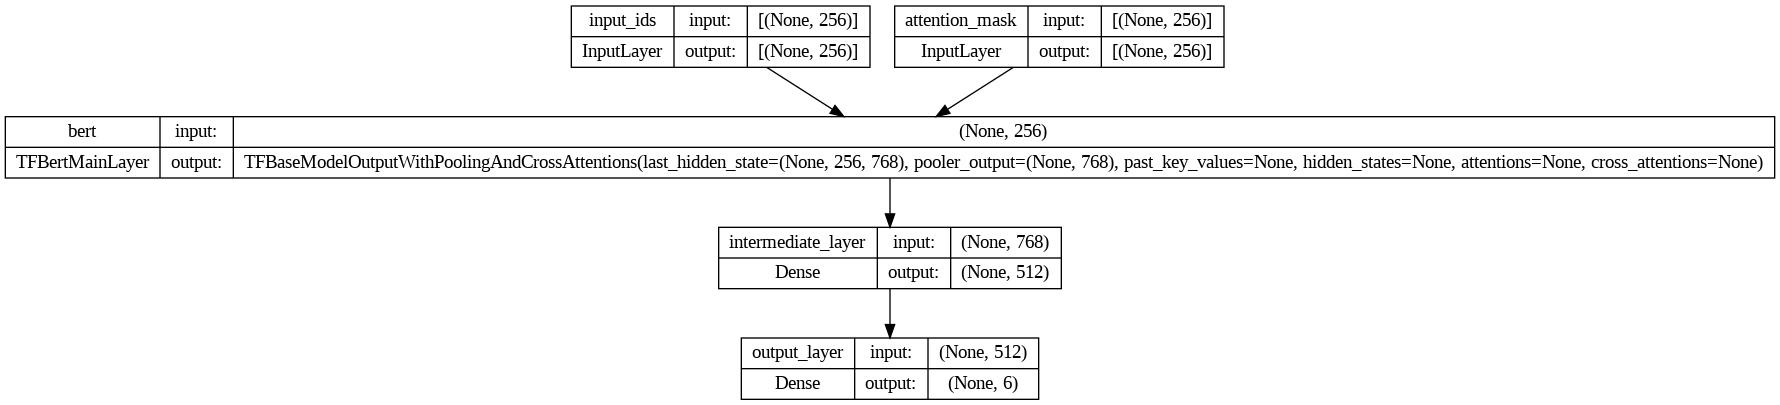

In [34]:
from tensorflow.keras.utils import plot_model
plot_model(blooms_model, to_file='blooms_model.png', show_shapes=True, show_layer_names=True)

In [35]:
blooms_model.save('blooms_model')

In [41]:
blooms_model.evaluate(val_dataset)

35/35 [==============================] - 10s 281ms/step - loss: 0.0205 - accuracy: 0.9893


[0.020475134253501892, 0.9892857074737549]

### **Prediction**

In [36]:
blooms_model = tf.keras.models.load_model('blooms_model')

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=['remember', 'understand', 'apply', 'analyze', 'evaluate','create']):
    probs = blooms_model.predict(processed_data)[0]
    return classes[np.argmax(probs)]

In [59]:

# Assuming you have a new data point or a list of new data points
new_data_point = "evaluate a text classification model that can identify fake news."

# Preprocess the new data using the same tokenizer
new_processed_data = prepare_data(new_data_point, tokenizer)

# Reshape the input to match the model's input shape
new_input_ids = np.reshape(new_processed_data['input_ids'], (1, -1))
new_attention_mask = np.reshape(new_processed_data['attention_mask'], (1, -1))

# Make predictions
new_predictions = blooms_model.predict([new_input_ids, new_attention_mask])
classes=['remember', 'understand', 'apply', 'analyze', 'evaluate', 'create']

# Convert predictions to class label
predicted_class = classes[np.argmax(new_predictions)]

print(f"Predicted class: {predicted_class}")


1/1 [==============================] - 0s 65ms/step
Predicted class: create


In [61]:
input_text = input('Enter Question here: ')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(blooms_model, processed_data=processed_data)
print(f"Predicted blooms level: {result}")

Enter Question here: define the krushkal's aglorithm
1/1 [==============================] - 3s 3s/step
Predicted blooms level: remember
